In [2]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pycircstat import mean as cmean, cdiff
from library.utils import load_pickle

# ====================================== Global params and paths ==================================
legendsize = 8
load_dir = 'sim_results/fig6'
save_dir = 'plots/FigNWGtalk/'
os.makedirs(save_dir, exist_ok=True)
plt.rcParams.update({'font.size': legendsize,
                     "axes.titlesize": legendsize,
                     'axes.labelpad': 0,
                     'axes.titlepad': 0,
                     'xtick.major.pad': 0,
                     'ytick.major.pad': 0,
                     'lines.linewidth': 1,
                     'figure.figsize': (5.2, 5.5),
                     'figure.dpi': 300,
                     'axes.spines.top': False,
                     'axes.spines.right': False,
                     })

In [183]:
def get_neighbors(nid, dims):
    # Get neighboring 8 indices after unravelling to a 2D matrix according to dims,
    # clockwise starting from 12 o'clock

    rid, cid = np.unravel_index(nid, dims)

    # Check boundary conditions
    dim1, dim2 = dims
    ridmax, ridmin = rid+1, rid-1
    cidmax, cidmin = cid+1, cid-1

    if (ridmax > (dim1-1)) or (cidmax > (dim2-1)) or (ridmin < 0) or (cidmin < 0):
        return None, (rid, cid)
    else:
        nid1 = np.ravel_multi_index((ridmin, cid), dims)
        nid2 = np.ravel_multi_index((ridmin, cidmax), dims)
        nid3 = np.ravel_multi_index((rid, cidmax), dims)
        nid4 = np.ravel_multi_index((ridmax, cidmax), dims)
        nid5 = np.ravel_multi_index((ridmax, cid), dims)
        nid6 = np.ravel_multi_index((ridmax, cidmin), dims)
        nid7 = np.ravel_multi_index((rid, cidmin), dims)
        nid8 = np.ravel_multi_index((ridmin, cidmin), dims)
        neighbors = np.array([nid1, nid2, nid3, nid4, nid5, nid6, nid7, nid8])
        return neighbors, (rid, cid)


In [188]:
exintag = 'ex'
if exintag == 'in':
    center_x, center_y = 0, 20
elif exintag == 'ex':
    center_x, center_y = 0, -20
else:
    raise ValueError

simdata = load_pickle(join(load_dir, 'fig6_%s.pkl' % exintag))

BehDF = simdata['BehDF']
SpikeDF = simdata['SpikeDF']
NeuronDF = simdata['NeuronDF']
MetaData = simdata['MetaData']
config_dict = simdata['Config']

theta_phase_plot = BehDF['theta_phase_plot']
traj_x = BehDF['traj_x'].to_numpy()
traj_y = BehDF['traj_y'].to_numpy()
traj_a = BehDF['traj_a'].to_numpy()
t = BehDF['t'].to_numpy()
theta_phase = BehDF['theta_phase'].to_numpy()

nn_ca3 = MetaData['nn_ca3']

xxtun1d = NeuronDF['neuronx'].to_numpy()
yytun1d = NeuronDF['neurony'].to_numpy()
aatun1d = NeuronDF['neurona'].to_numpy()

xxtun1d_ca3 = xxtun1d[:nn_ca3]
yytun1d_ca3 = yytun1d[:nn_ca3]
aatun1d_ca3 = aatun1d[:nn_ca3]
nx_ca3, ny_ca3 = config_dict['nx_ca3'], config_dict['ny_ca3']
xxtun2d_ca3 = xxtun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny
yytun2d_ca3 = yytun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny
aatun2d_ca3 = aatun1d_ca3.reshape(nx_ca3, nx_ca3)  # Assuming nx = ny

Ipos_max_compen = config_dict['Ipos_max_compen']
Iangle_diff = config_dict['Iangle_diff']
Iangle_kappa = config_dict['Iangle_kappa']
xmin, xmax, ymin, ymax = config_dict['xmin'], config_dict['xmax'], config_dict['ymin'], config_dict['ymax']
theta_f = config_dict['theta_f']  # in Hz
theta_T = 1 / theta_f * 1e3  # in ms
dt = config_dict['dt']
traj_d = np.append(0, np.cumsum(np.sqrt(np.diff(traj_x) ** 2 + np.diff(traj_y) ** 2)))

SpikeDF['tsp'] = SpikeDF['tidxsp'].apply(lambda x: t[x])
all_nidx = []
spdftmplist = []
for nid in range(nn_ca3):
    spdf_each = SpikeDF[(SpikeDF['neuronid'] == nid) & (SpikeDF['tidxsp'] > 105000) & (SpikeDF['tidxsp'] <= 106000)]
    num_sp = spdf_each.shape[0]
    if num_sp > 0:
        all_nidx.append(nid)
        spdftmplist.append(spdf_each)
all_nidx = np.sort(np.array(all_nidx))
SpikeDF_subset = pd.concat(spdftmplist, ignore_index=True)


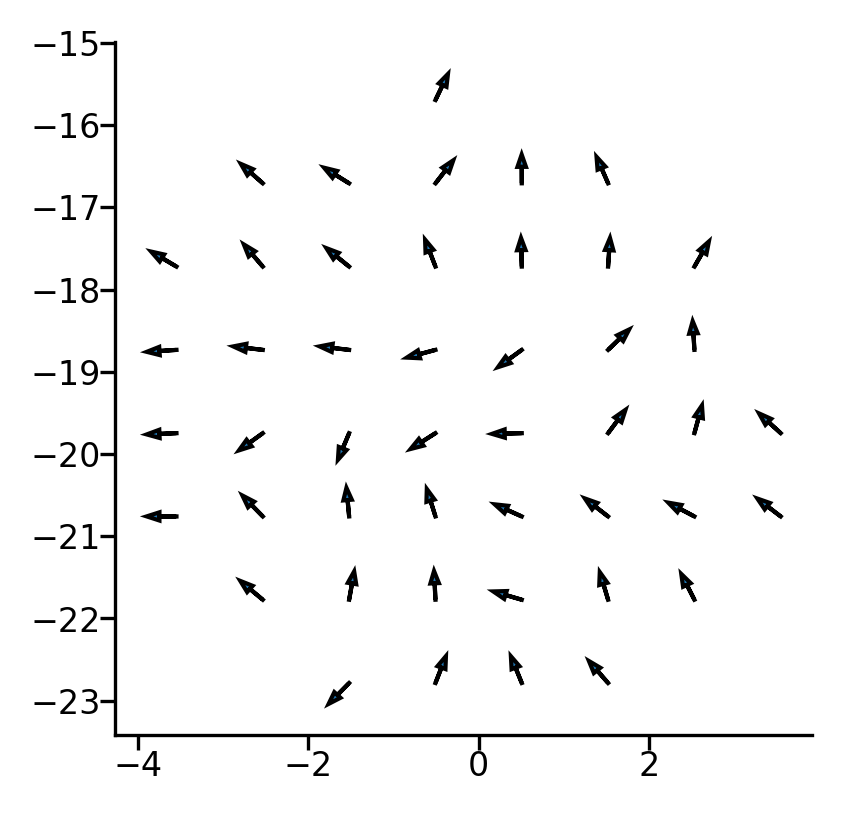

In [189]:

geo_degs = np.array([270,315, 0, 45, 90, 135, 180, 225])
geo_rads = np.deg2rad(geo_degs)

neuronx = xxtun1d_ca3[all_nidx]
neurony = yytun1d_ca3[all_nidx]
neuron_phase = np.zeros(all_nidx.shape[0])

fig, ax = plt.subplots(figsize=(3, 3))
# ax.scatter(neuronx, neurony)



for i, nidx in enumerate(all_nidx):
    neighbors, (rid, cid) = get_neighbors(nidx, (nx_ca3, ny_ca3))
    centerx, centery = xxtun1d_ca3[nidx], yytun1d_ca3[nidx]

    spdf_MN = SpikeDF_subset[SpikeDF_subset['neuronid'] == nidx]
    tidxsp = spdf_MN['tidxsp'].to_numpy()
    if tidxsp.shape[0] > 1:
        phase_center = cmean(theta_phase[tidxsp])
    elif tidxsp.shape[0] == 1:
        phase_center = theta_phase[tidxsp]
    else:
        phase_center = None



    if (neighbors is not None):

        # Check if all the neighbors are inside the admitted population
        true_neighs = []
        for neiid in neighbors:
            if neiid in all_nidx:
                true_neighs.append(True)
            else:
                true_neighs.append(False)

        if np.sum(true_neighs) > 7:

            neigh_x = xxtun1d_ca3[neighbors]
            neigh_y = yytun1d_ca3[neighbors]

            geo_vec = neigh_x - centerx + 1j * (neigh_y - centery)
            geo_rad = np.angle(geo_vec)

            phasediff = np.zeros(neighbors.shape[0])
            for j, neiid in enumerate(neighbors):

                spdf_MN = SpikeDF_subset[SpikeDF_subset['neuronid'] == neiid]
                tidxsp = spdf_MN['tidxsp'].to_numpy()
                if tidxsp.shape[0] > 1:
                    phase_neigh = cmean(theta_phase[tidxsp])
                elif tidxsp.shape[0] == 1:
                    phase_neigh = theta_phase[tidxsp]
                else:
                    phase_neigh = None

                phasediff[j] = phase_neigh - phase_center

            mean_vec = np.sum(phasediff * np.exp(1j * geo_rad))/phasediff.shape[0]
            mean_vec = np.exp(1j * np.angle(mean_vec))
            mean_vec = mean_vec /5
            ax.arrow(centerx, centery, np.real(mean_vec), np.imag(mean_vec), head_width=0.1)


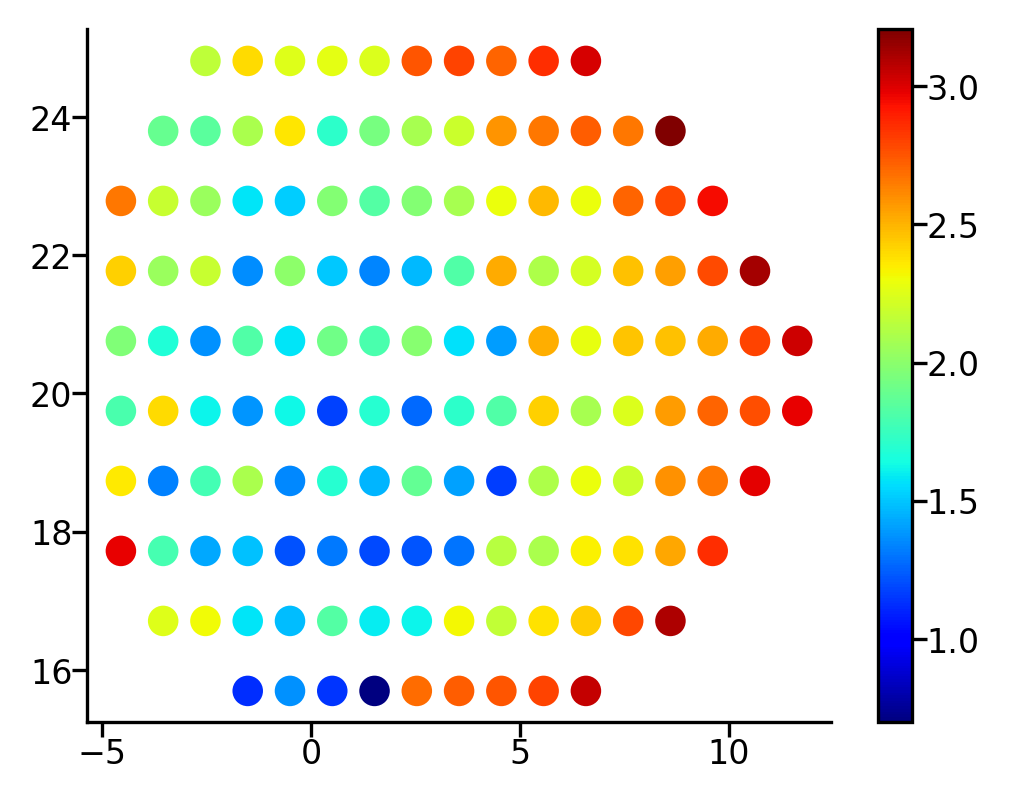

In [187]:


neuronx = xxtun1d_ca3[all_nidx]
neurony = yytun1d_ca3[all_nidx]
neuron_phase = np.zeros(all_nidx.shape[0])
for i, nidx in enumerate(all_nidx):
    spdf_MN = SpikeDF_subset[SpikeDF_subset['neuronid'] == nidx]
    tidxsp = spdf_MN['tidxsp'].to_numpy()

    if tidxsp.shape[0] > 1:
        phase = cmean(theta_phase[tidxsp])
    elif tidxsp.shape[0] == 1:
        phase = theta_phase[tidxsp]
    else:
        phase = None

    neuron_phase[i] = phase

fig, ax = plt.subplots(figsize=(4, 3))
im = ax.scatter(neuronx, neurony, c=neuron_phase, cmap='jet', s=40)
plt.colorbar(im, ax=ax)




(0.0, 1000.0)

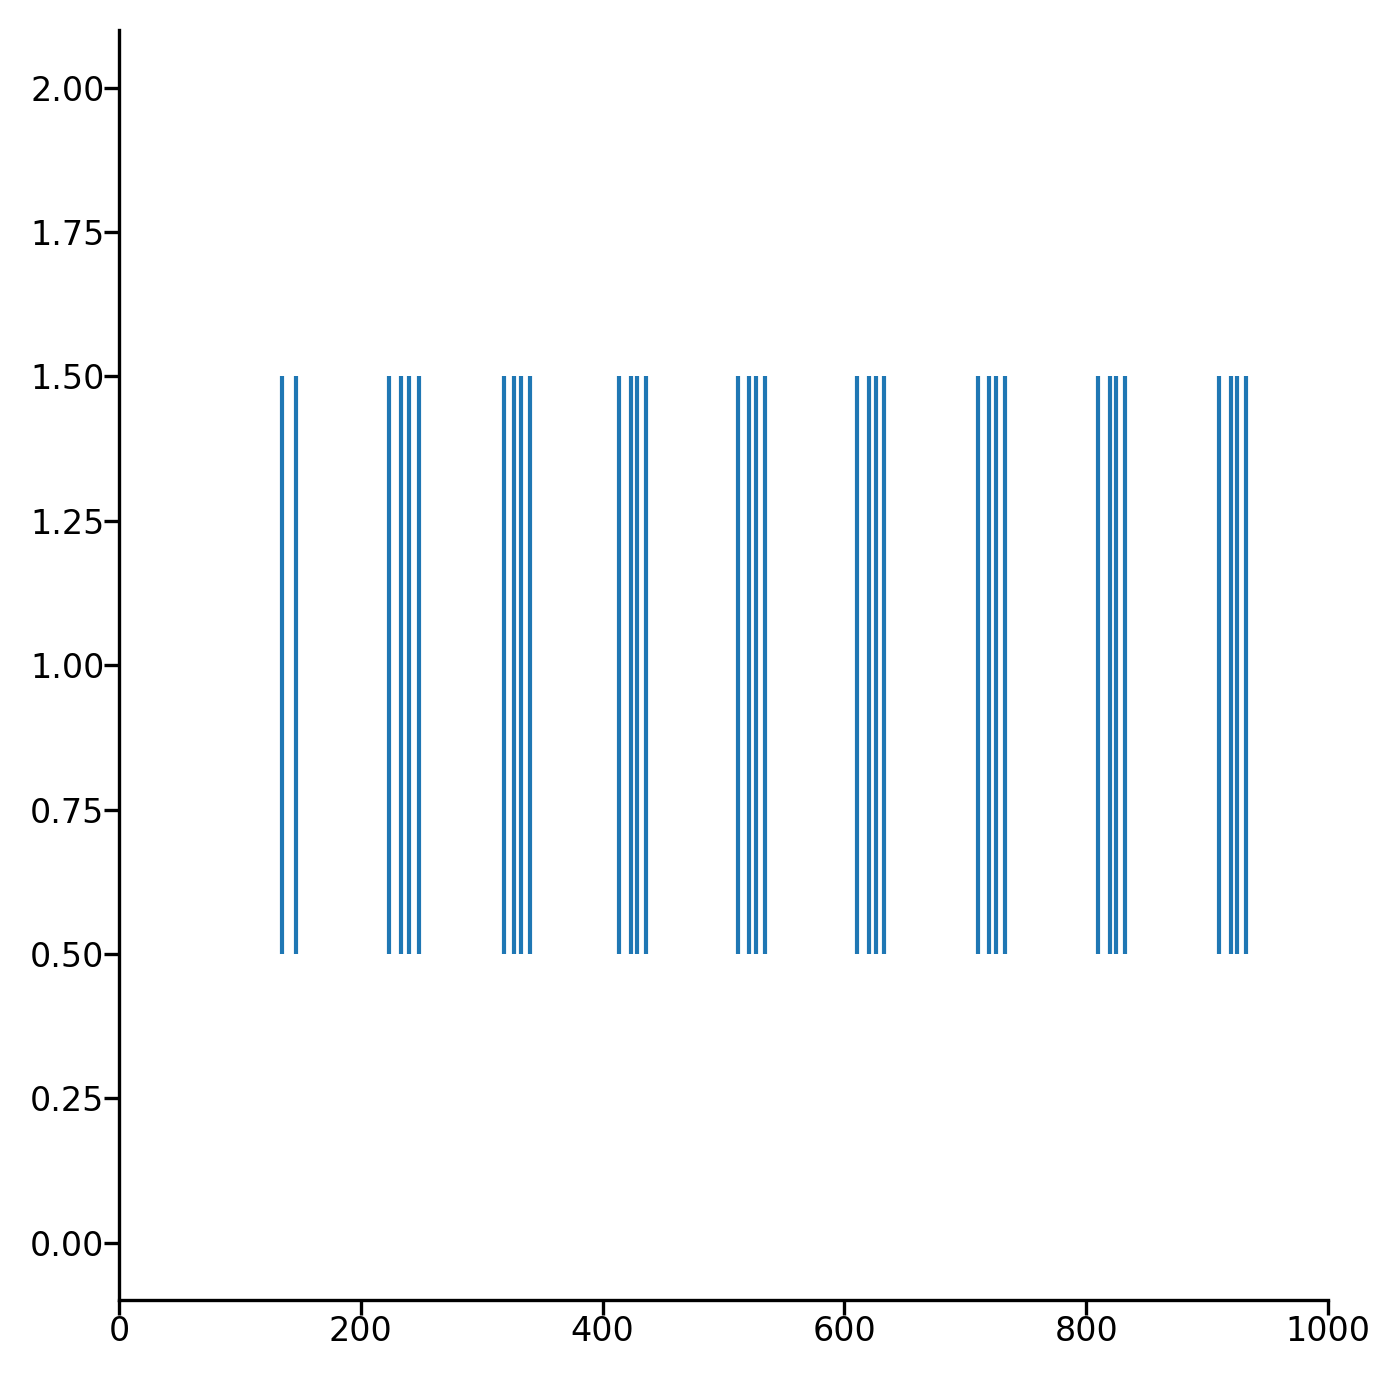

In [150]:
spdf_MN = SpikeDF[SpikeDF['neuronid'] == all_nidx[43]]
plt.eventplot(spdf_MN['tsp'])
plt.xlim(0, 1000)

In [180]:
BehDF[BehDF['traj_type']==9]

,t,traj_x,traj_y,traj_a,traj_type,Itheta,theta_phase,theta_phase_plot
100000,10000.0,7.071068,-27.071068,2.356194,9,7.000000,0.000000,0.000000
100001,10000.1,7.069653,-27.069653,2.356194,9,6.999931,0.006283,0.006283
100002,10000.2,7.068239,-27.068239,2.356194,9,6.999724,0.012566,0.012566
100003,10000.3,7.066825,-27.066825,2.356194,9,6.999378,0.018850,0.018850
100004,10000.4,7.065410,-27.065410,2.356194,9,6.998895,0.025133,0.025133
...,...,...,...,...,...,...,...,...
109995,10999.5,-7.065410,-12.934590,2.356194,9,6.998273,6.251769,6.251769
109996,10999.6,-7.066825,-12.933175,2.356194,9,6.998895,6.258053,6.258053
109997,10999.7,-7.068239,-12.931761,2.356194,9,6.999378,6.264336,6.264336
109998,10999.8,-7.069653,-12.930347,2.356194,9,6.999724,6.270619,6.270619


In [181]:
np.rad2deg(2.356)

134.98885653282196